In [1]:
#IMPORT DELLE LIBRERIE
import numpy as np 
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

import skimage.transform as trans
from skimage import io, color
from skimage.util import random_noise

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [10]:
#DOWNLOAD DEL DATASET
lfw_dataset=fetch_lfw_people(resize=0.256,download_if_missing=True,slice_=None,color=True)
print(lfw_dataset.images.shape)
X=lfw_dataset.images
y=lfw_dataset.target


#SPLIT DEL DATASET PER IL TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2)

#SPLIT DEL DATASET PER IL VALIDATION SET
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.1)


(13233, 64, 64, 3)


In [11]:
#DIMENSIONI DEL TRAINING SET
X_train.shape

(9527, 64, 64, 3)

In [12]:
#DIMENSIONI DEL TEST SET
X_test.shape

(2647, 64, 64, 3)

In [14]:
#DIMENSIONI DEL VALIDATION SET
X_val.shape

(1059, 64, 64, 3)

In [15]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI
noise_factor = 0.2

X_train_noisy = random_noise(X_train, mode="s&p",clip=True, amount=noise_factor)
X_test_noisy = random_noise(X_test, mode="s&p",clip=True, amount=noise_factor)
X_val_noisy = random_noise(X_val, mode="s&p",clip=True, amount=noise_factor)

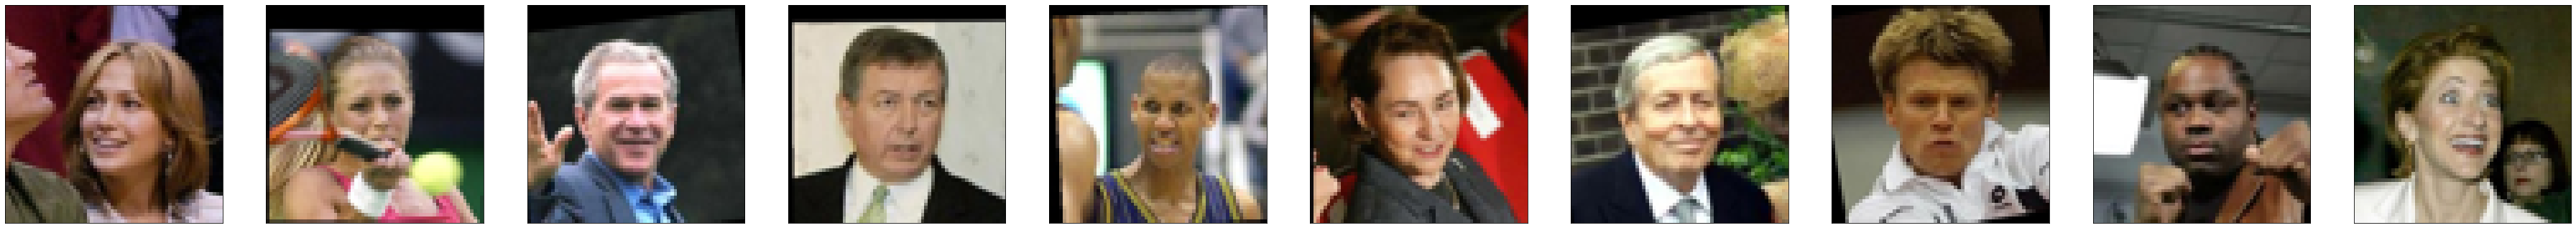

In [16]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

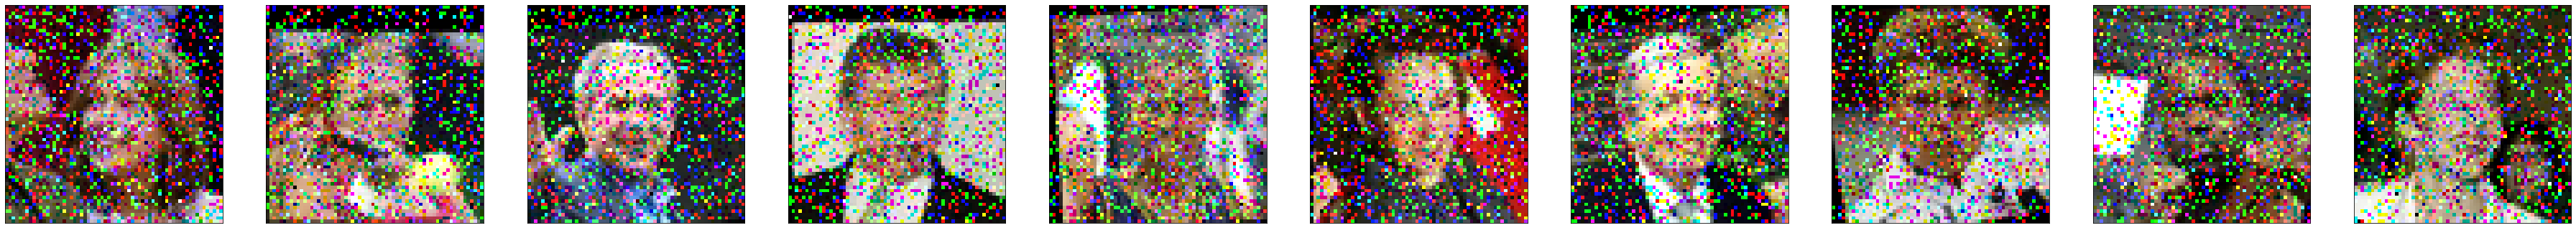

In [17]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET COL RUMORE
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, ReLU, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

In [19]:
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')

        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.bn_3 = BatchNormalization()
        self.bn_4 = BatchNormalization()
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        # X = self.bn_1(X)
        X = ReLU()(X)
        X = self.conv_2(X)
        # X = self.bn_2(X)
        X = ReLU()(X)
        X = self.conv_3(X)
        # X = self.bn_3(X)
        X = ReLU()(X)
        # X = self.conv_4(X)
        # # X = self.bn_4(X)
        # X = ReLU()(X)

        return X

In [20]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)   

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [24]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4 

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))


In [29]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(64,64,3))

    cb_1 = Conv_block(num_filters=64)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=128)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    cb_3 = Conv_block(num_filters=256)(dwt_2)
    dwt_3 = DWT_downsampling()(cb_3)

    cb_4 = Conv_block(num_filters=512)(dwt_3)
    dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=512)(dwt_4)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=512)(cb_5)
    cb_5 = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same')(cb_5)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=512)(Add()([up, cb_4]))
    up = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=256)(Add()([up, cb_3]))
    up = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(up)
    
    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=128)(Add()([up, cb_2]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)
    
    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_1]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=3, kernel_size=(1, 1), padding="same")(up)

    return Model(inputs=[input], outputs=[out])

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_block (Conv_block)        (None, 64, 64, 64)   75648       ['input_1[0][0]']                
                                                                                                  
 dwt_downsampling (DWT_downsamp  (None, 32, 32, 256)  0          ['conv_block[0][0]']             
 ling)                                                                                            
                                                                                                  
 conv_block_1 (Conv_block)      (None, 32, 32, 128)  590208      ['dwt_downsampling[0][0]']   

In [30]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse')

In [32]:
#TRAINING DEL MODELLO
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)
history = model.fit(X_train_noisy, X_train, epochs=100, batch_size=16, validation_data=(X_val_noisy,X_val), callbacks=[callback])

Epoch 1/100
596/596 [==============================] - 94s 157ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 2/100
596/596 [==============================] - 91s 152ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/100
596/596 [==============================] - 88s 148ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 4/100
596/596 [==============================] - 88s 148ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/100
596/596 [==============================] - 88s 148ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/100
596/596 [==============================] - 88s 148ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
596/596 [==============================] - 88s 148ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
596/596 [==============================] - 89s 149ms/step - loss: 0.0011 - val_loss: 9.8450e-04
Epoch 9/100
596/596 [==============================] - 91s 153ms/step - loss: 0.0010 - val_loss: 9.1272e-04
Epoch 10/100
596/596 [==============================] - 

In [33]:
#TEST DEL MODELLO SUL TEST SET
predict = model.predict(X_test_noisy)

83/83 [==============================] - 9s 80ms/step


In [34]:
predict.shape

(2647, 64, 64, 3)

In [35]:
n=10

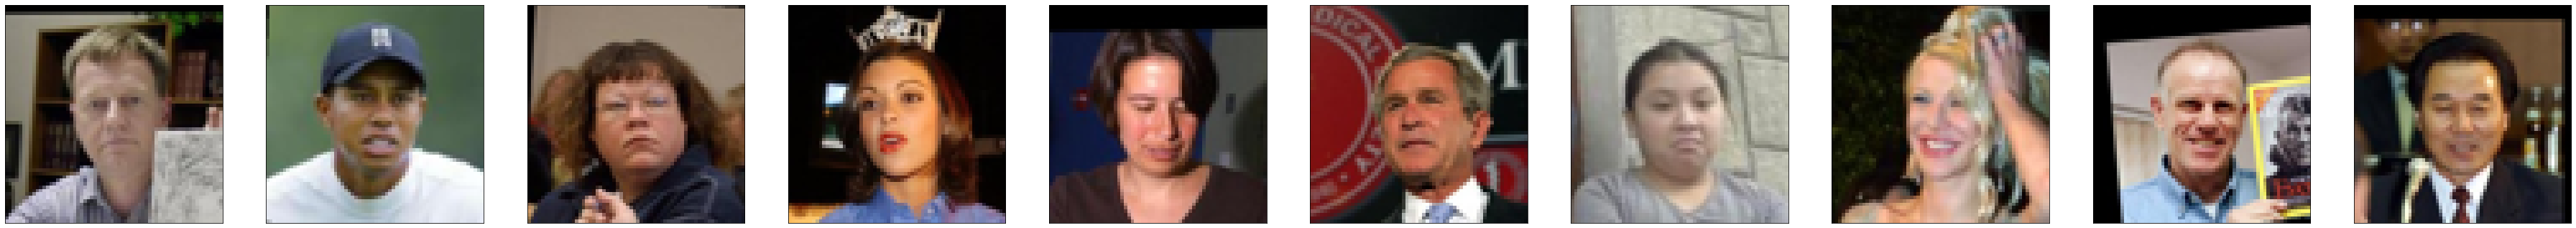

In [36]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

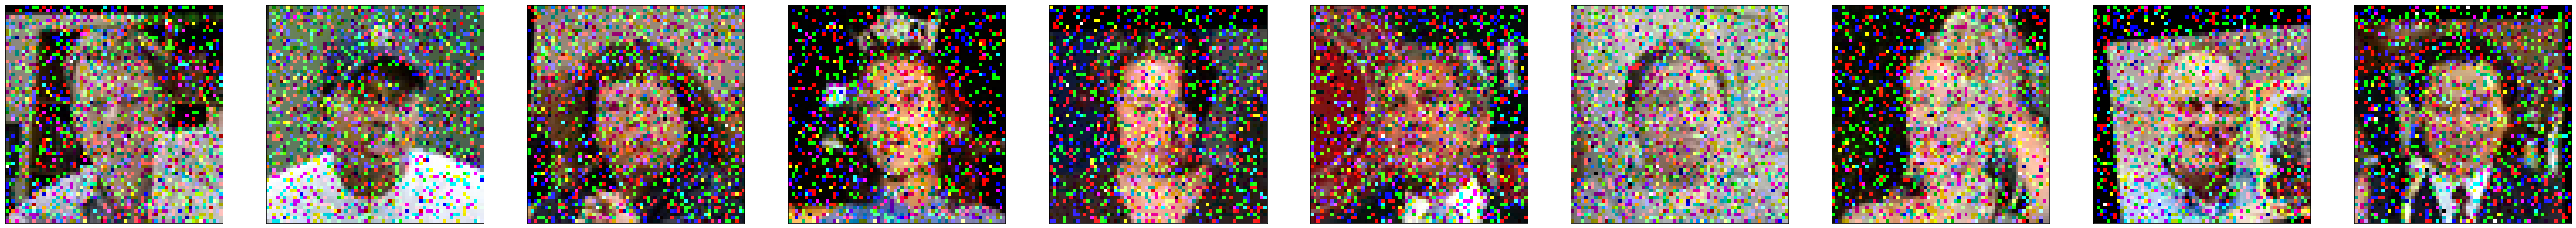

In [37]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET COL RUMORE
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

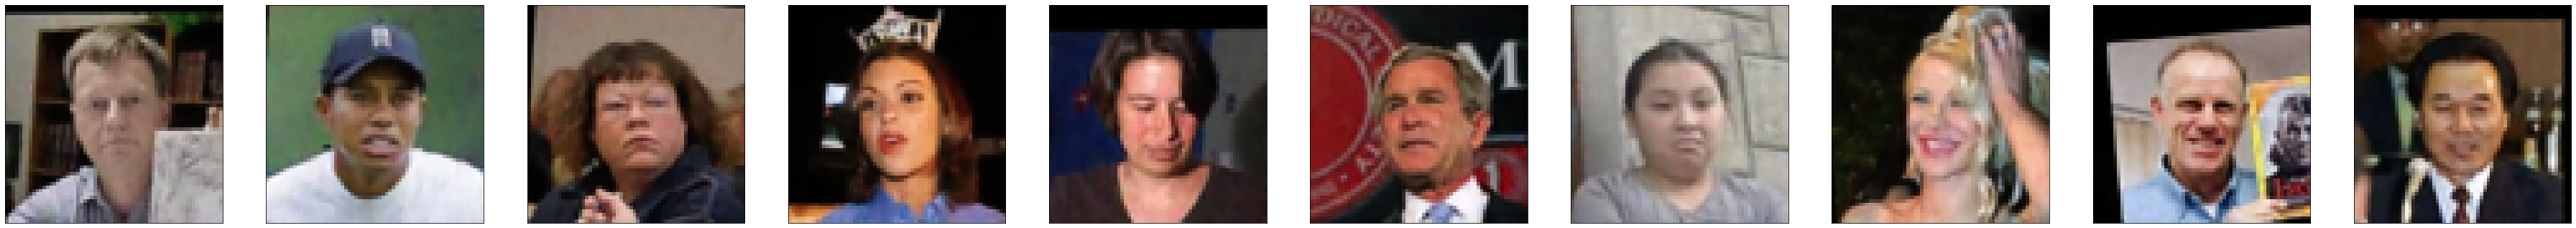

In [38]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET SENZA RUMORE (OUTPUT DELLA UNET)
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
NUMBER_OF_TEST_IMAGES = len(X_test)

mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.0005845451
Mean Absolute Error: 0.017415747
Root Mean Squared Error: 0.024177367


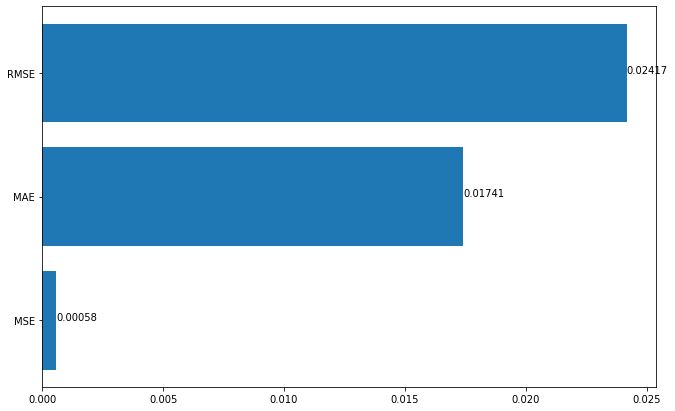

In [40]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()